Vehicle Detection Project
---

In [87]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import random
import math

%matplotlib inline

Load the data
---


In [23]:
import glob
import time

# Divide up into cars and notcars
cars = glob.glob('data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('data/non-vehicles/**/*.png', recursive=True)

# cloading car images
car_image = []
for impath in cars:
    car_image.append (mpimg.imread(impath))

# loading non car images
notcar_image = []
for impath in notcars:
    notcar_image.append (mpimg.imread(impath))

car_image_count = len (car_image)
notcar_image_count = len (notcar_image)

print ('dataset has cars:', car_image_count)
print ('none cars:', notcar_image_count)

dataset has cars: 8792
none cars: 8968


Show some example image
---

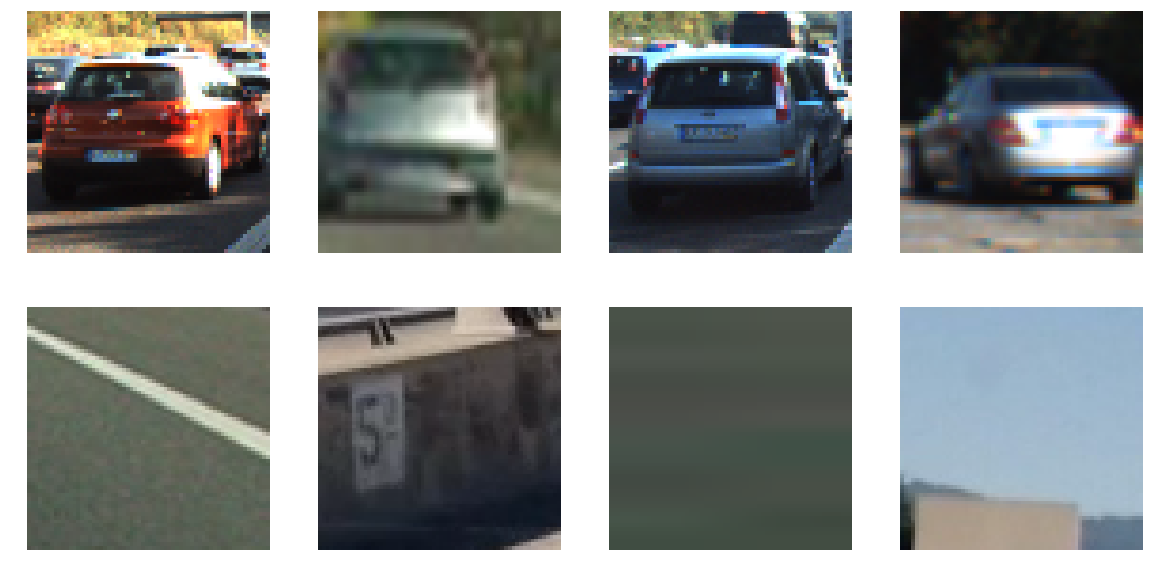

In [56]:
example_images = [
    
    # car images
    car_image[random.randint(0, car_image_count-1)],
    car_image[random.randint(0, car_image_count-1)],
    car_image[random.randint(0, car_image_count-1)],
    car_image[random.randint(0, car_image_count-1)],
    
    # not car images
    notcar_image[random.randint(0, notcar_image_count-1)],
    notcar_image[random.randint(0, notcar_image_count-1)],
    notcar_image[random.randint(0, notcar_image_count-1)],
    notcar_image[random.randint(0, notcar_image_count-1)]
]

show_images_array(example_images, (4, 2), fig_size=(20, 10))

Feature Extraction Functions
---

In [43]:
# Function to extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # if true, return hog images too
    if vis == True: 
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # otherwise just return regular features
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

def bin_spatial2(img, size=(32, 32)):
    ch1 = cv2.resize(img[:,:,0], size).ravel() 
    ch2 = cv2.resize(img[:,:,1], size).ravel() 
    ch3 = cv2.resize(img[:,:,2], size).ravel() 
    features = np.concatenate ([ch1, ch2, ch3])
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist


# another version, could define bin range separately
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    #print(img.shape)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [101]:

# Function to extract spatial, color and hog features from single image
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
       
    img_features = []
    
    # Apply color conversion if necessary
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)      
    
    # Compute spatial features if requested
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    # Compute histogram features if requested
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    # Compute HOG features if requested
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                                            pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        img_features.append(hog_features)

    return np.concatenate(img_features)



# function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
   
    # Iterate through the list of images
    for image in imgs:
        
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
       
        if hog_feat == True:
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))

    return features


# Define search windows for the main program
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64),
                              interpolation=cv2.INTER_AREA)      
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    return on_windows


# Function to define a list of sliding windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    # read image size
    imgsizey = img.shape [0]
    imgsizex = img.shape [1]
    x_start_stop [0] = 0 if x_start_stop [0] is None else x_start_stop [0]
    x_start_stop [1] = imgsizex if x_start_stop [1] is None else x_start_stop [1]
    y_start_stop [0] = 0 if y_start_stop [0] is None else y_start_stop [0]
    y_start_stop [1] = imgsizey if y_start_stop [1] is None else y_start_stop [1]
    
    # Compute the span of the region to be searched
    sizex = x_start_stop [1] - x_start_stop [0]
    sizey = y_start_stop [1] - y_start_stop [0]
    
    # Compute the number of pixels per step in x/y
    stepx = int (xy_window [0] * xy_overlap [0])
    stepy = int (xy_window [1] * xy_overlap [1])
    
    # Compute the number of windows in x/y
    step_count_x = int (math.floor(1.0 * sizex / stepx)) - 1
    step_count_y = int (math.floor(1.0 * sizey / stepy)) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    for i in range (step_count_y):
        for j in range (step_count_x):
            # Calculate each window position
            # Append window position to list
            window_list.append ((
                (x_start_stop [0] + j*stepx, y_start_stop [0] + i*stepy),
                (x_start_stop [0] + j*stepx + xy_window [0], y_start_stop [0] + i*stepy + xy_window [1])))
    
    return window_list


# Function to draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thickness=5):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thickness)
    # Return the image copy with boxes drawn
    return imcopy


def get_s_from_hls (img):
    hls = cv2.cvtColor (img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]

In [96]:

# Define parameters for feature extraction
color_space = 'GRAY' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcar_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=9)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#svc = LinearSVC(loss='hinge') # Use a linear SVC 
svc = SVC() # Use a SVC 

t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Car samples:  8792
Notcar samples:  8968
Using: 8 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 128
6.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


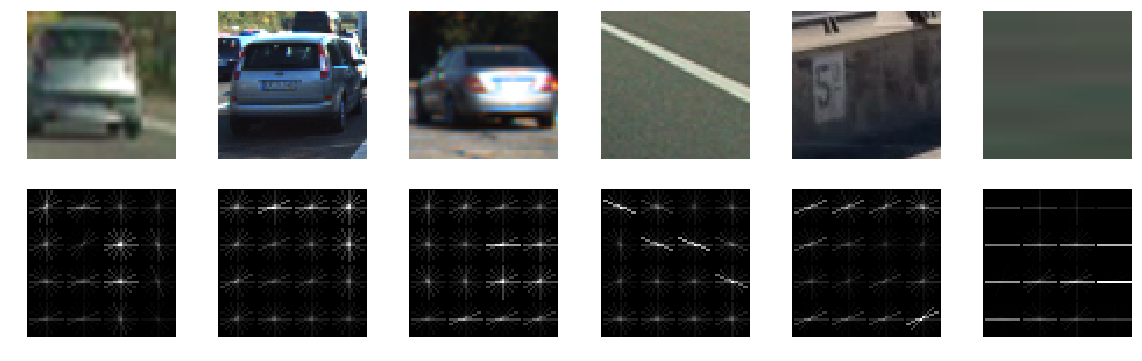

In [100]:
images_features = list(example_images [1:-1])

feature_examples = []
feature_examples.extend(images_features)

for im in images_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append(hog_image)
    
show_images_array(feature_examples, (6, 2), fig_size=(20, 6))

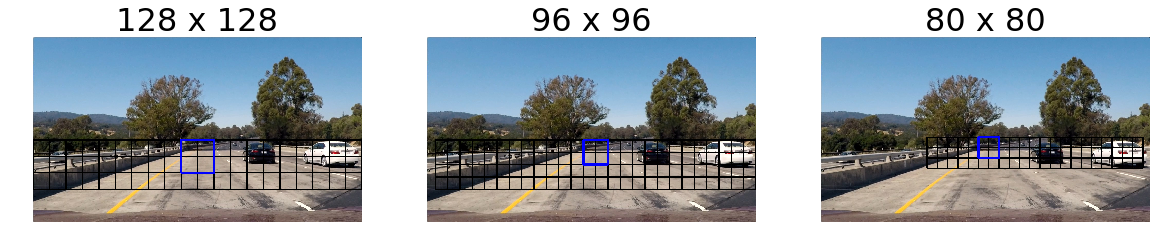

In [104]:
image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [[None, None],
               [32, None],
               [412, 1280]]

sw_y_limits = [[400, 640],
               [400, 600],
               [390, 540]]

sw_window_size = [[128, 128],
                  [96, 96],
                  [80, 80]]

sw_overlap = [[0.5, 0.5],
              [0.5, 0.5],
              [0.5, 0.5]]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append(draw_boxes(np.copy(image), windows, color=(0, 0, 0), thickness=3))
sliding_windows.append(draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thickness=3))
sliding_windows.append(draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thickness=3))

# drawing one of sliding windows in blue
sliding_windows[0] = draw_boxes(sliding_windows[0], [windows[9]], color=(0, 0, 255), thickness=8)
sliding_windows[1] = draw_boxes(sliding_windows[1], [windows2[12]], color=(0, 0, 255), thickness=8)
sliding_windows[2] = draw_boxes(sliding_windows[2], [windows3[5]], color=(0, 0, 255), thickness=8)

sw_titles = ['128 x 128', '96 x 96', '80 x 80']

show_images_in_table (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

In [72]:
# Applies sliding windows to images and finds hot windows.
def get_hot_boxes (image):
   
    dst = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(dst, x_start_stop=x_limits, y_start_stop=y_limits, 
                               xy_window=window_size, xy_overlap=overlap)

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        all_hot_windows.extend (hot_windows)

        dst = draw_boxes(dst, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, dst
        

# Function to calcualte heat map of hot windows
def get_heat_map(image, bbox_list):
   
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    return heatmap


# Class to store average hot boxes. Including methods to get the joint boxes
class AverageHotBox ():
   
    # Init
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    # Function to return number of joined boxes
    def get_strength (self):
        return self.detected_count
    
    
    # Function to get all boxes associated with the main class
    def get_box (self):

        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return ((center[0] - half_width, center[1] - half_height), 
                    (center[0] + half_width, center[1] + half_height))
        
        else:
            return self.boxes[0]
    
    
    # function to check if two boxes are close enough for joining: criterion 30% overlap
    def is_close (self, box):

        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (intersection >= 0.3 * area1 or intersection >= 0.3 * area2):
            return True
        
        else:
            return False
    
    # funtion to join all boxes
    def join (self, boxes):
        
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                joined = True

        return joined

# Function to output average box, the final output
def calc_average_boxes (hot_boxes, strength):
  
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes


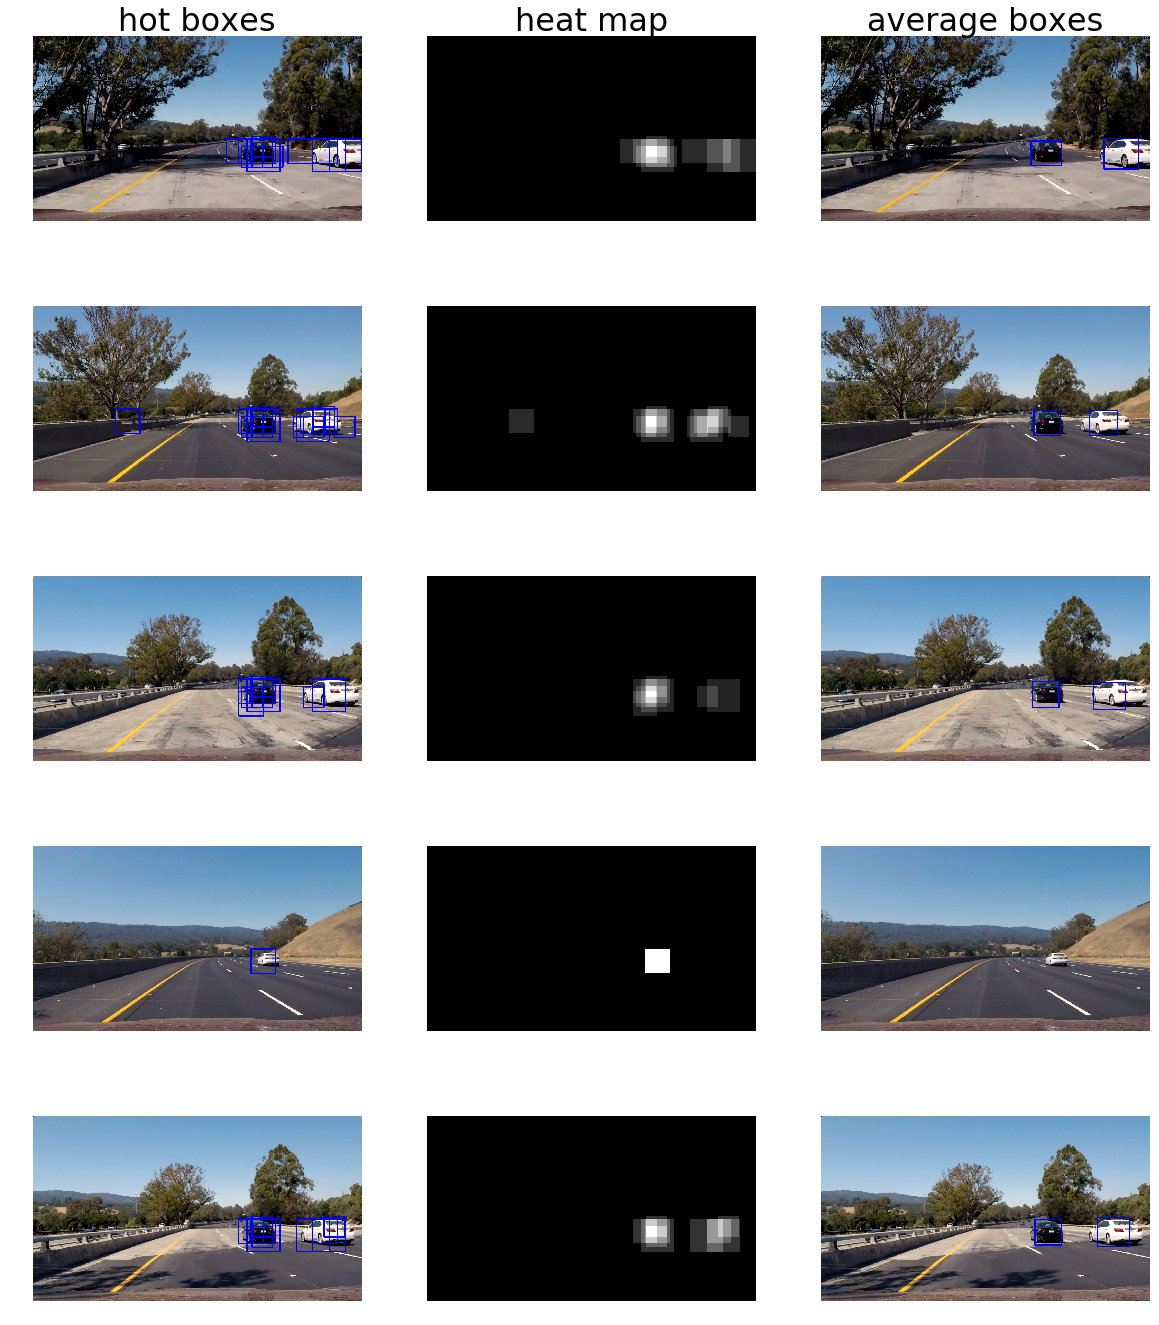

In [97]:
# Result on test still images
test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images_in_table (test_images, (3, 5), fig_size=(20, 24), titles=test_images_titles)

In [83]:
# Use information from at past 10 frames, to reduce false positives and 
# make the algorithm more robust

# Class for accumulation of hot boxes from last 10 frames
class LastHotBoxesQueue ():

    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

        
    def put_hot_boxes (self, boxes):
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
    
    # Get hot boxes from last 10 frames
    def get_hot_boxes (self):
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

    
last_hot_boxes = LastHotBoxesQueue ()
    
def process_image (image_orig):
    
    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255
    
    # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()
    
    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes * 255

In [99]:
from moviepy.editor import VideoFileClip


def process_video(input_path, output_path):
    clip = VideoFileClip(input_path)
    

    result = clip.fl_image(process_image)
    %time result.write_videofile(output_path, audio=False)


#process_video ('test_video.mp4', 'test_video_result.mp4')
process_video ('project_video.mp4', 'project_video_result.mp4')



[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [06:08<00:00,  3.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 5min 58s, sys: 2.3 s, total: 6min
Wall time: 6min 10s


In [47]:
# Functions to display images
def show_images_array(images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)
    plt.show ()
    

def plt_show_gray (image):
    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):
    plt.figure ()
    plt.imshow (image)
    plt.show ()
    
